![Header Image](../assets/header_image.png "Header Image")

# Assignment 5: 3D Object Detection

Welcome to this assignment where we have a detailed view on 3D LiDAR object detection. __Obect detection__ in general is a popular computer vision task which overall goal is the assignment of _a bounding box and a classifcation__ to every occuring object in the input scene. In this assignment we will focus on the 3D space, where we perform object detection on real 3D LiDAR point clouds. The image below gives an example of the output of our algorithm.

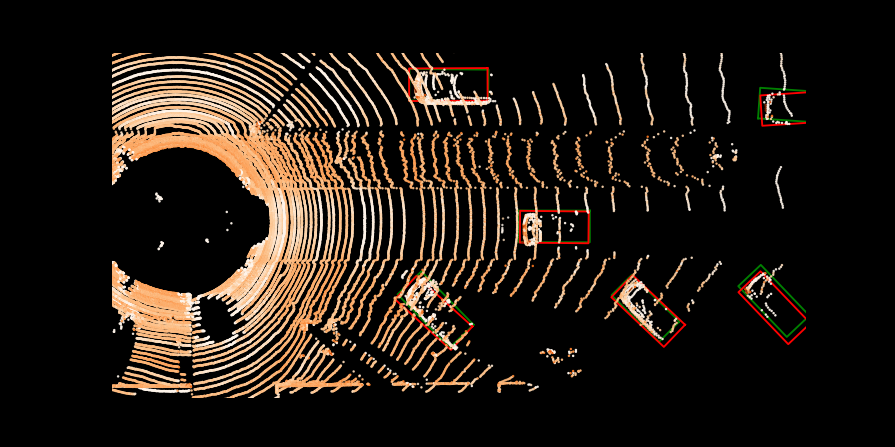

The output boxes are detected by a state-of-the-art architecure for object detection, namely [PointPillars](https://arxiv.org/abs/1812.05784).

In this assignment we will walk through the following steps:

- Loading a dataset for 3D object detection
- Preprocess those input point clouds and labels
- Creating a Tensorflow model architecture
- Setting training parameters and train the model
- Perform inference on the model

### Installation and Import 
This assignment mainly depends on a modified [tensorflow implementation](https://github.com/ika-rwth-aachen/PointPillars) of [PointPillars]((https://arxiv.org/abs/1812.05784). We already installed a `point_pillars` python package and setup everything within this notebook. Next, we include all dependencies and setup our workspace correctly. After this step we are ready to start with the first part of this exercise.

In [ ]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import cv2
import numpy as np
import tensorflow as tf
from glob import glob 

import matplotlib.pyplot as plt
import math
from beeprint import pp

from point_pillars import createPillars

sys.path.append('object_detection')
from object_detection.config import Parameters
from object_detection.loss import PointPillarNetworkLoss
from object_detection.processors import SimpleDataGenerator
from object_detection.readers import KittiDataReader
from object_detection.inference_utils import generate_bboxes_from_pred, rotational_nms

from object_detection.utils import setUpPlot, plot2DVertices, plot2DLabel, plot2DBox, transform_labels_into_lidar_coordinates
from object_detection.utils import build_pillar_net, build_detection_head

DATA_ROOT = "datasets/kitti"
MODEL_ROOT = "object_detection/model"

## Parameters
Training neural networks is a complex and powerful task requiring lots of different settings. To get a better overview, the following command shows the default parameters in the [config.py](object_detection/config.py) of the PointPillars environment. 

In [ ]:
params = Parameters()
pp(Parameters)

Here, parameters for building up the network architecture, for the training process itself, as well as parameters for building the anchor boxes exist. This overview here serves only as a brief overview. Keep in mind, that we have to change some of those parameters later.

## Dataset

For the development of object detection approaches, especially when using deep learning methods, large datasets are required. Therefore, we will use the [3D Object Detection Evaluation](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d) data set which consists of 7481 manually annotated point clouds. The pointclouds are stored in the directory `datasets/kitti/velodyne` with corresponding labels in `datasets/kitti/label_2`. In this assignment we will only use 200 of those labeled point clouds due to the time consuming training. Nevertheless, we start the assignment by a short observation of the available data.

### Task 1: Plot sample 3D point cloud with labels 

The first task of this assignment is the visualization of the available input. The python package [Matplotlib](https://matplotlib.org/) offers a variaty of useful methods. In addition the `KittiDataReader` class provides functions for simple input reading.

```
read_lidar(file_name)
read_label(file_name)
read_calibration(file_name)
```

The special aspect of the KITTI dataset is that labels and point clouds are recorded in different coordinate systems, which is why calibration files has to be used as well. The already implemented function `transform_labels_into_lidar_coordinates` does the label transformation into the LiDAR coordinate system for you. 

Now, your task is to visualize the labels within the point cloud, where 2D labels from the bird's eye view are sufficient for simplicity. Therefore you have a list of `label3D` objects and the already implemented function `plot2DLabels` which takes the four vertices of a label as input and plots the rectangular shape. Complete the `None` places in the code so that executing the cell will plot the labels in the bird's eye view correctly.

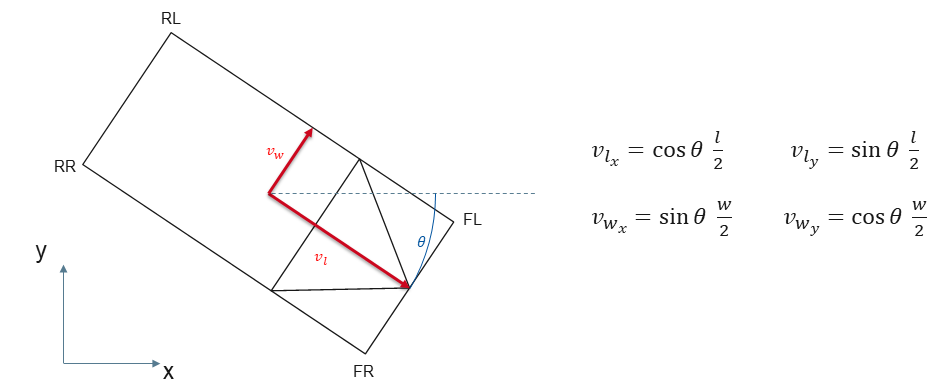

Hints:
- calculate the four vertices FL (front left), FR (front right), RL (rear left) and RR (rear right) - start from the centroid and navigate to each of the four vertices
- you will need the length $l$, width $w$ and the yaw $\theta$ angle of the labels
- the z coordinate remains for all vertices as in the centroid, because we only visualize a 2D label from the bird eye view
- set up a list of length three for every corner vertice
- the following visualizes the already mentioned hints above - start with calculating $v_l$ and $v_w$

In [ ]:
%matplotlib widget

# sample index for plotting
idx = 10

# read data
data_reader = KittiDataReader()
lidar = data_reader.read_lidar(os.path.join(DATA_ROOT, "velodyne", str(idx).zfill(6)+".bin"))
label = data_reader.read_label(os.path.join(DATA_ROOT, "label_2", str(idx).zfill(6)+".txt"))
R, t = data_reader.read_calibration(os.path.join(DATA_ROOT, "calib", str(idx).zfill(6)+".txt"))
label_transformed = transform_labels_into_lidar_coordinates(label, R, t)

# plot settings
ax = setUpPlot()

# plot sample pointcloud
ax.scatter(lidar[:,0], lidar[:,1], lidar[:,2], c=lidar[:,3], cmap='Oranges', s=1)

# plot labels
for l in label_transformed:
    
    x = l.centroid[0] 
    y = l.centroid[1]
    z = l.centroid[2]
    length = l.dimension[0]
    width = l.dimension[1]
    height = l.dimension[2]
    yaw = l.yaw

    ### START TASK 1 CODE

    v_l_x = None
    v_l_y = None
    
    v_w_x = None
    v_w_y = None
    
    FL = [None, None, None]
    FR = [None, None, None]
    RL = [None, None, None]
    RR = [None, None, None]

    ### END TASK 1 CODE
    
    plot2DVertices(ax, FL, FR, RR, RL)

### Expected Output:
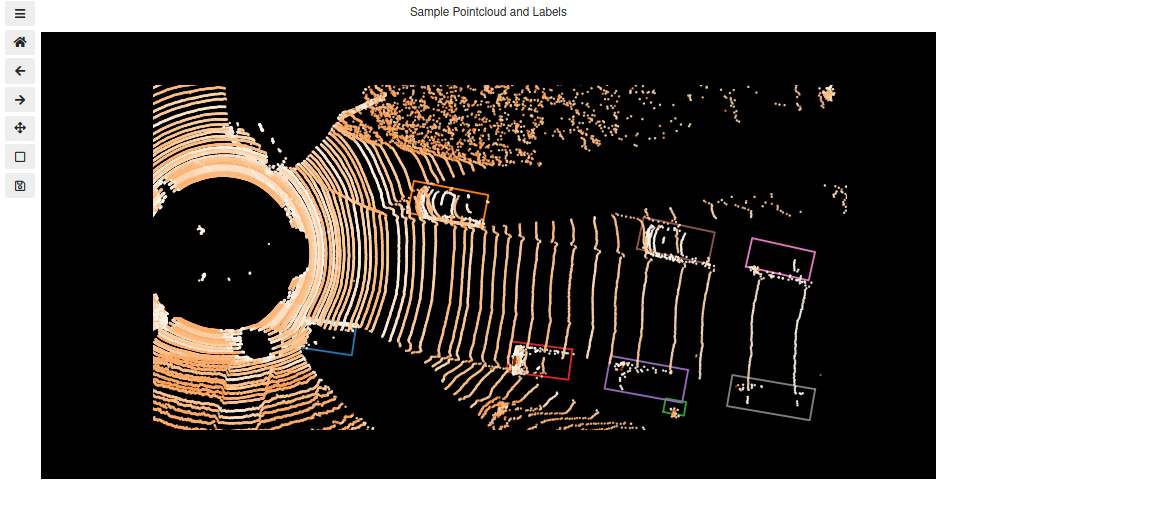

### Task 2: Training / Validation / Test Split
Training neural networks requires several preprocessing steps. In addition to steps as data augmentation or normalization, data has to be loaded and distributed to training, validation, and test datasets. For the split into these three datasets one often finds a 70/20/10 split in literature, so you should apply the same split to the 100 samples from the KITTI dataset.

Your task is to create the three datasets with the class `SimpleDataGenerator` and its constructor:
```
def __init__(self, data_reader: DataReader, batch_size: int, lidar_files: List[str], label_files: List[str] = None,  calibration_files: List[str] = None):
```

Replace all `None` in the code so that the three datasets are created.

Hints: 
- create the lengths of each dataset; lengths should be integers and the sum of all datasets should sum up to the total sample size
- the KITTI dataset is unsorted so that the split can be performed without shuffling
- create file lists for lidar, label and calib data and each dataset (training, validation, and test)
- use the `SimpleDataGenerator` class to create the datasets
- you will need the defined `batch_size` of the `params` object

In [ ]:
data_reader = KittiDataReader()

lidar_files = sorted(glob(os.path.join(DATA_ROOT, "velodyne", "*.bin")))
label_files = sorted(glob(os.path.join(DATA_ROOT, "label_2", "*.txt")))
calibration_files = sorted(glob(os.path.join(DATA_ROOT, "calib", "*.txt")))

m = len(label_files)

### START TASK 2 CODE

## define lengths of each dataset
training_len = None
validation_len = None
test_len = None

# distribute lidar_files, label_files and calibration_files to training, validation, and test
lidar_training = None
label_training = None
calib_training = None

lidar_validation = None
label_validation = None
calib_validation = None

lidar_test = None
label_test = None
calib_test = None

# create the datasets by using the `SimpleDataGenerator`
training_gen = None
validation_gen = None
test_gen = None

### END TASK 2 CODE

print("Defined training files: ", training_len, " training batches:", len(training_gen))
print("Defined validation files: ", validation_len, " validation batches:", len(validation_gen))
print("Defined test files: ", test_len, " test batches:", len(test_gen))

### Expected Output:

Note: The batch size is set to 4, because of large memory consumption of LiDAR point clouds. Hence, only small batch sizes are typically feasible.

## Network Architecture

Especially in the last years, deep learning methods have demonstrated improved and powerful results in lots of areas. One state of the art neural network architecture for the computer vision task of 3D object detection is [PointPillars](https://arxiv.org/abs/1812.05784).

The basic idea is deviding the task in three parts:
- pillar feature network for creating grid based feature map
- typical 2D CNN backbone
- detection head for prediction of 3D bounding boxes

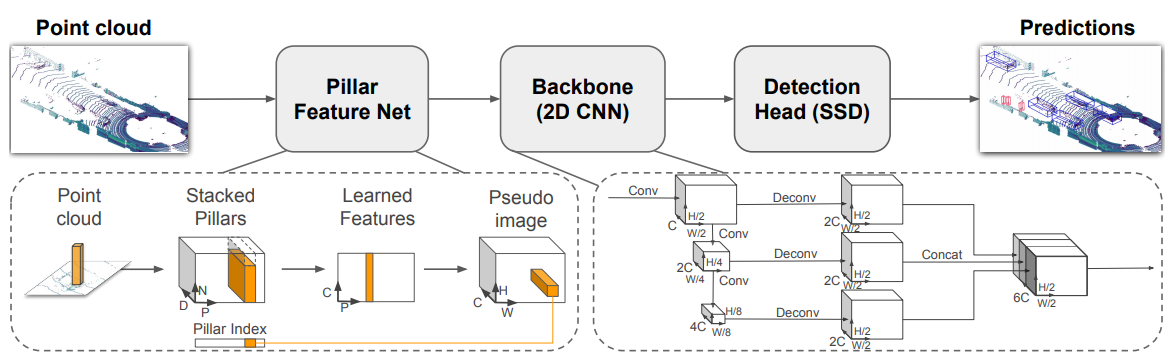

We do not want to go into detail, since we are not a machine learning course, but the figure above shows a short overview of the network architecture which we have to build in [Tensorflow](https://www.tensorflow.org/) in the following steps. If you are interested please read here for the full paper about [PointPillars](https://arxiv.org/abs/1812.05784).

### Task 3: Building Neural Network Model
Since the entire structure of the PoinPillars network is complicated and beyond the scope of this assignment, we focus in our task on the Convolutional Neural Network (CNN) backbone.
This U-net shaped CNN structure consists of the main blocks shown in the figure above. The top-down structure consists of three individual blocks, each consisting of several convolutional layers together with batch normalization operating on different stride levels:

- Block1 (4, C): 4 convolutional layers, C=64 output filters
- Block2 (6, 2C): 6 convolutional layers, 2C=128 output filters
- Block3 (6, 2C): 6 convolutional layer, 2C=128 output filters 

The filter size is fixed to `3x3` with `stride` S. S is Also, `same` padding and `Relu` activation is applied in each block identically.

Replace the `None` placeholders in the function `build_cnn_backbone` to implement the second block and analogous to blocks 1 and 3.

Hints:
- structure is analogous to block 1 and 3
- function [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) can be used to apply a convolutional layer
- function [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) can be used to apply batch norm 

In [ ]:
def build_cnn_backbone(pillars, params):

    nb_channels = int(params.nb_channels)

    # 2d cnn backbone

    # Block1(4, C)
    x = pillars
    for n in range(4):
        S = (2, 2) if n == 0 else (1, 1)
        x = tf.keras.layers.Conv2D(nb_channels, (3, 3), strides=S, padding="same", activation="relu",
                                   name="cnn/block1/conv2d%i" % n)(x)
        x = tf.keras.layers.BatchNormalization(name="cnn/block1/bn%i" % n, fused=True)(x)
    x1 = x

    # Block2(6, 2C)
    ### START TASK 3 CODE


    ### END TASK 3 CODE
    
    # Block3(6, 2C)
    for n in range(6):
        S = (2, 2) if n == 0 else (1, 1)
        x = tf.keras.layers.Conv2D(2 * nb_channels, (3, 3), strides=S, padding="same", activation="relu",
                                   name="cnn/block3/conv2d%i" % n)(x)
        x = tf.keras.layers.BatchNormalization(name="cnn/block3/bn%i" % n, fused=True)(x)
    x3 = x

    # Up1 (S, S, 2C)
    up1 = tf.keras.layers.Conv2DTranspose(2 * nb_channels, (3, 3), strides=(1, 1), padding="same", activation="relu",
                                          name="cnn/up1/conv2dt")(x1)
    up1 = tf.keras.layers.BatchNormalization(name="cnn/up1/bn", fused=True)(up1)

    # Up2 (2S, S, 2C)
    up2 = tf.keras.layers.Conv2DTranspose(2 * nb_channels, (3, 3), strides=(2, 2), padding="same", activation="relu",
                                          name="cnn/up2/conv2dt")(x2)
    up2 = tf.keras.layers.BatchNormalization(name="cnn/up2/bn", fused=True)(up2)

    # Up3 (4S, S, 2C)
    up3 = tf.keras.layers.Conv2DTranspose(2 * nb_channels, (3, 3), strides=(4, 4), padding="same", activation="relu",
                                          name="cnn/up3/conv2dt")(x3)
    up3 = tf.keras.layers.BatchNormalization(name="cnn/up3/bn", fused=True)(up3)

    # Concat
    concat = tf.keras.layers.Concatenate(name="cnn/concatenate")([up1, up2, up3])

    return concat

### Test your implemented function `build_cnn_backbone`

In [ ]:
# create inputs
input_pillars = tf.keras.layers.Input((params.max_pillars, params.max_points_per_pillar, params.nb_features), batch_size=params.batch_size, name="pillars/input")
input_indices = tf.keras.layers.Input((params.max_pillars, 3), batch_size=params.batch_size, name="pillars/indices", dtype=tf.int32)
    
# create pillar_net, consisting of the three subparts
pillars = build_pillar_net(input_pillars, input_indices, params)

cnn = build_cnn_backbone(pillars, params)

pillar_net = build_detection_head(cnn, input_pillars, input_indices, params)

print(pillar_net.summary())

### Expected Results:

### Callbacks, Loss and Optimizer
We now defined some callback functions to save current training status and monitor the overall training progress.

In [ ]:
epoch_to_decay = int(np.round(params.iters_to_decay / params.batch_size * int(np.ceil(float(len(label_files)) / params.batch_size))))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=MODEL_ROOT, profile_batch=0),
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_ROOT, "model.h5"),
                                       monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.8 if ((epoch % epoch_to_decay == 0) and (epoch != 0)) else lr, verbose=True),
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
]

Now we set `Adam` as optimizer and define the losses. Have a look into `PointPillarNetworkLoss` in [loss.py](object_detection/loss.py) for a detailed overview of the different loss parts, which are a localization loss, a dimension loss, an angle and heading loss and finally a classification loss. 

In a last step the model is compiled using the [`compile()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) function.

In [ ]:
# setup optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate, decay=params.decay_rate)
loss = PointPillarNetworkLoss(params)

# compile tensorflow model
pillar_net.compile(optimizer, loss=loss.losses())

## Training
After preparing the datasets and creating and compiling the model, it's time to perform our first 3D object detection training using the PointPillars network architecture. 



### Task 4: Training

For training, we use the tensorflow-keras function `fit()`. This function takes as an input the training and validation datasets, as well as the callbacks and all relevant other training parameters. Your task is to set up this function correctly and train the network with the training and validation sub-dataset for one epoch. 

The training takes about 2:30 min when training with one epoch. __Note__: One epoch is totally fine for us here. We provided a full trained network for all further steps.

Hints: 
- use the tensorflow function [fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)
- use the already created datasets `training_gen`, `validation_gen` as well as the `callbacks` list
- the steps_per_epoch is the length of the dataset `training_gen`
- use multiprocessing
- use one epoch
- use 6 workers

In [ ]:
### START TASK 4 CODE


history = pillar_net.fit(
    
    
    
    
    
                        )

### END TASK 4 CODE

print(history.history)

## Inference 

### Load Pretrained Model
Since useful training on a large variable trainingset often takes lots of hours or sometimes days we provided such a full-trained model in `object_detection/model/model_pretrained.h5`. The following cell loads the model, which now shows much better performance in the next inference tasks, than our self-trained model.

In [ ]:
pillar_net.load_weights(os.path.join(MODEL_ROOT, "pretrained_model.h5"))

### Prediction
We can now perform __inference__ on that pretrained model by loading a sample from the dataset and use the model's `predict` function.

In [ ]:
occupancy, position, size, angle, heading, classification = pillar_net.predict(test_gen, batch_size=params.batch_size)

print("Occupancy shape: ", occupancy.shape)
print("Position shape: ", position.shape)
print("Size shape: ", size.shape)
print("Angle shape: ", angle.shape)
print("Heading shape: ", heading.shape)
print("Classification shape: ", classification.shape)

The output are tensors where for each sample (8), every grid cell (252 x 252), and every anchor (4) a given target is computed. As already described in the loss setup, different tensors are created for the different tasks. While occupancy, angle and heading prediction are single values, the anchor's output for the position and size are vectors.

## Filtering and Non-Maximum Suppresion
In a further step, the computed targets for each anchor are processed and classified bounding boxes are generated. Therefore, only predictions with a confidence score probability above a certain threshold `score_threshold` are considered.

Finally, remaining bounding boxes are filtered by using Non-Maximum Suppression. The `iou_threshold` determines the second threshold discussed on the slides.

### Task 5: Finding suitable thresholds
The last task for this assignment is about finding good fitting thresholds for postprocessing. In real applications, evaluation metrics, as discussed in lecture, are used for the determination of thresholds. For simplicity, however, this assignment is about finding suitable parameters manually. Therefore, find suitable parameters with the predictions of the eight test samples, respectively:
- `score_threshold`
- `iou_threshold`

Hint: 
- use the plot script below for a simple visualization 
- green boxes mark the ground truth 
- blue boxes mark the PointPillars detections after filtering and non-maximum suppression

In [ ]:
### START TASK 5 CODE

# Hint: a small threshold results in too many, a high threshold in too few detections
score_threshold = 0.5
iou_threshold = 0.5

### END TASK 5 CODE

set_boxes, confidences = [], []
loop_range = occupancy.shape[0] if len(occupancy.shape) == 4 else 1

for i in range(loop_range):
    set_boxes.append(generate_bboxes_from_pred(occupancy[i], position[i], size[i], angle[i], heading[i], classification[i], params.anchor_dims, occ_threshold=score_threshold))
    confidences.append([float(boxes.conf) for boxes in set_boxes[-1]])

nms_boxes = rotational_nms(set_boxes, confidences, score_threshold=score_threshold, iou_threshold=iou_threshold)

### Plot Detections

In [ ]:
%matplotlib widget

# sample index for plotting
idx = 5

# read data
data_reader = KittiDataReader()
lidar = data_reader.read_lidar(lidar_test[idx])
label = data_reader.read_label(label_test[idx])
R, t = data_reader.read_calibration(calib_test[idx])
label_transformed = transform_labels_into_lidar_coordinates(label, R, t)

# plot settings
ax = setUpPlot()

# plot sample pointcloud
ax.scatter(lidar[:,0], lidar[:,1], lidar[:,2], c=lidar[:,3], cmap='Oranges', s=1)

# plot labels
for l in label_transformed:
    print(l)
    plot2DLabel(ax, l)
    
# plot detections
for d in nms_boxes[idx]:
    print(d)
    plot2DBox(ax, d)


## Wrap Up

- You learned about 3D object detection using a deep learning approach
- You learned about 3D bounding box representations
- You learned how to set up a Tensorflow model
- You learned how to train a 3D object detection model

## References

## License

MIT License

Copyright 2023 Institute for Automotive Engineering of RWTH Aachen University.